In [2]:
# -------------------
# Imports and Setup
# -------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from hmmlearn.hmm import GaussianHMM

# --- STONKS THEME COLORS ---
STONKS_GREEN = "#00ff9c"
STONKS_PINK  = "#ff4fd8"
STONKS_BLUE  = "#00cfff"
STONKS_PURPLE = "#a855f7"
BG = "#0f0f14"
GRID = "#2a2a38"

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.facecolor'] = BG
plt.rcParams['figure.facecolor'] = BG
plt.rcParams['grid.color'] = GRID

np.random.seed(42)

import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.sims.brownian import simulate_gbm
from src.sims.ou import simulate_ou
from src.sims.regime_switching import simulate_regime_switching

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

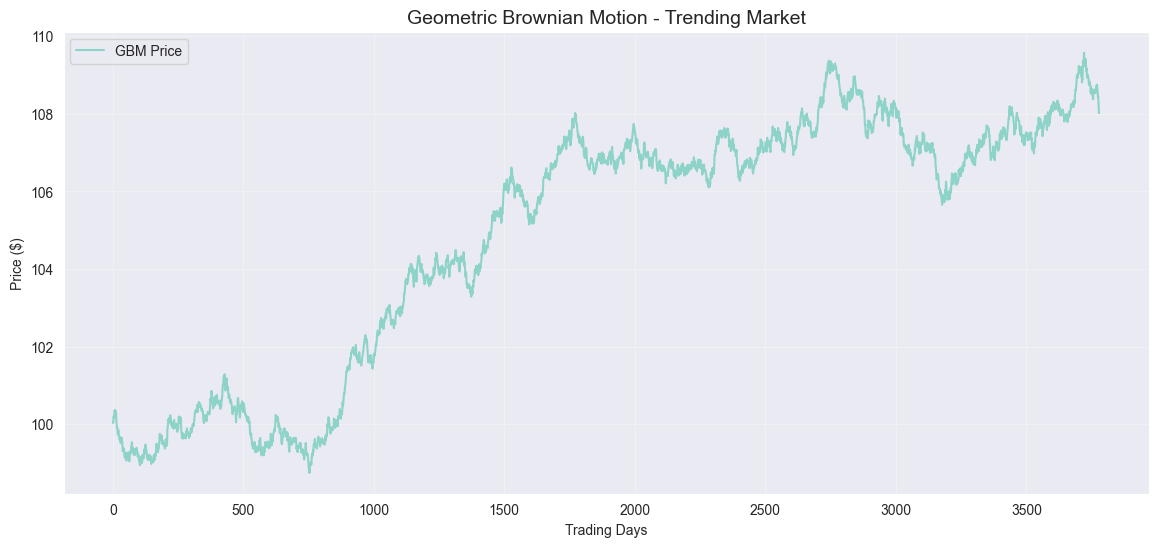

Total return: 7.98%
Daily volatility: 0.08%


In [4]:
gbm_data = simulate_gbm(mu=0.05, sigma=0.20, years=15, seed=42)

plt.figure(figsize=(14, 6))
plt.plot(gbm_data['close'], label='GBM Price', linewidth=1.5)
plt.title('Geometric Brownian Motion - Trending Market', fontsize=14)
plt.xlabel('Trading Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total return: {(gbm_data['close'].iloc[-1] / gbm_data['close'].iloc[0] - 1) * 100:.2f}%")
print(f"Daily volatility: {gbm_data['returns'].std() * 100:.2f}%")

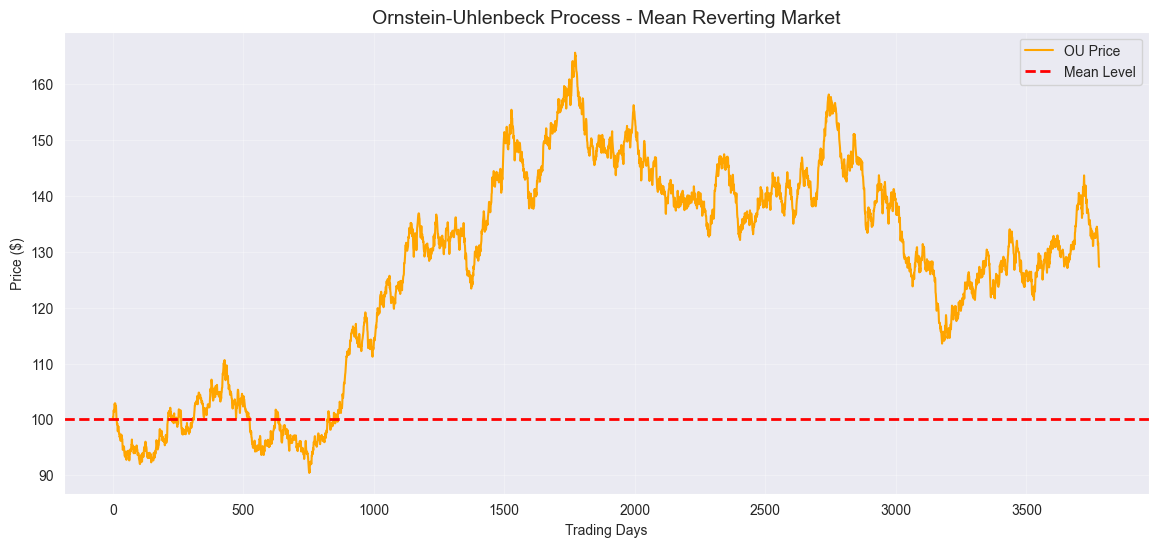

Mean price: $127.53
Std deviation: $18.81


In [6]:
ou_data = simulate_ou(theta=0.10, sigma=0.10, mean_level=np.log(100), years=15, seed=42)

plt.figure(figsize=(14, 6))
plt.plot(ou_data['close'], label='OU Price', linewidth=1.5, color='orange')
plt.axhline(y=100, color='red', linestyle='--', label='Mean Level', linewidth=2)
plt.title('Ornstein-Uhlenbeck Process - Mean Reverting Market', fontsize=14)
plt.xlabel('Trading Days')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Mean price: ${ou_data['close'].mean():.2f}")
print(f"Std deviation: ${ou_data['close'].std():.2f}")

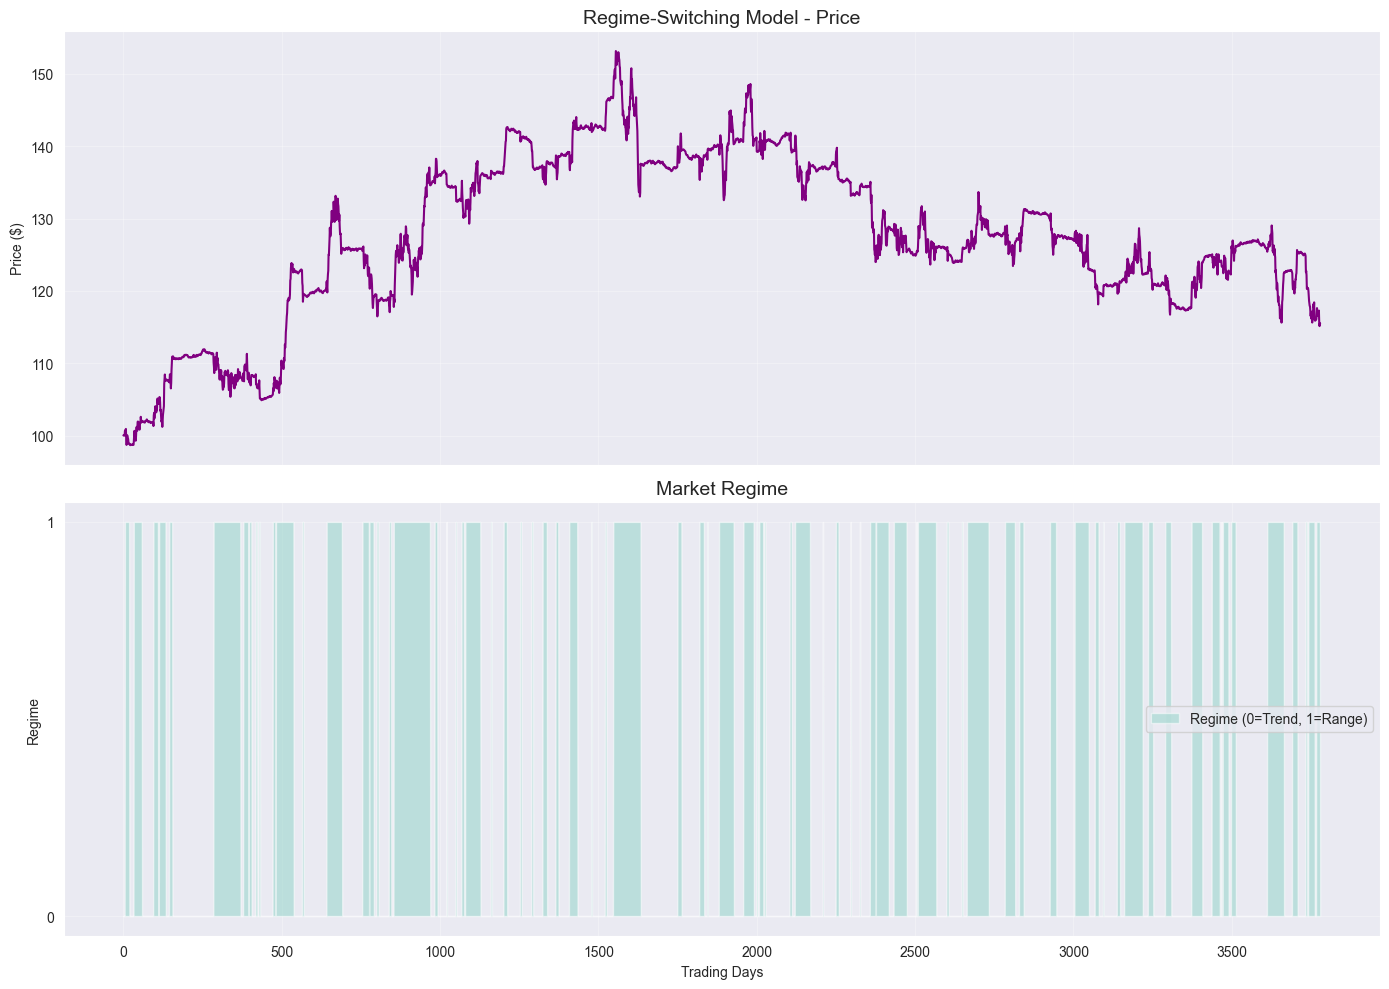

Trending: 58.2% of time
Range-bound: 41.8% of time


In [8]:
regime_data = simulate_regime_switching(
    trend_mu=0.06,
    trend_sigma=0.18,
    ou_theta=0.08,
    ou_sigma=0.12,
    p_trend_to_range=0.03,
    p_range_to_trend=0.05,
    years=15,
    seed=42
)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Price plot
ax1.plot(regime_data['close'], linewidth=1.5, color='purple')
ax1.set_title('Regime-Switching Model - Price', fontsize=14)
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# Regime plot
ax2.fill_between(regime_data.index, 0, regime_data['regime'], 
                  alpha=0.5, label='Regime (0=Trend, 1=Range)')
ax2.set_title('Market Regime', fontsize=14)
ax2.set_xlabel('Trading Days')
ax2.set_ylabel('Regime')
ax2.set_yticks([0, 1])
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

trend_pct = (regime_data['regime'] == 0).sum() / len(regime_data) * 100
print(f"Trending: {trend_pct:.1f}% of time")
print(f"Range-bound: {100-trend_pct:.1f}% of time")

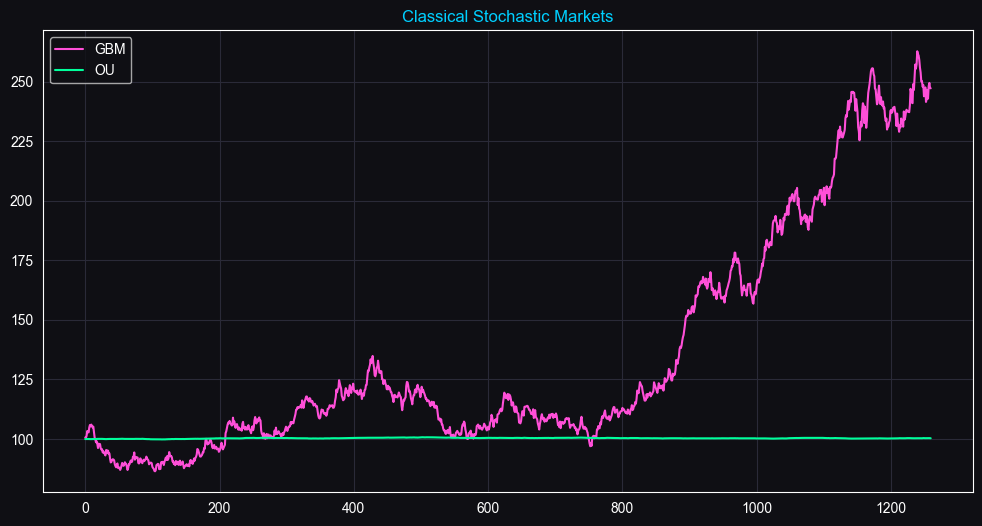

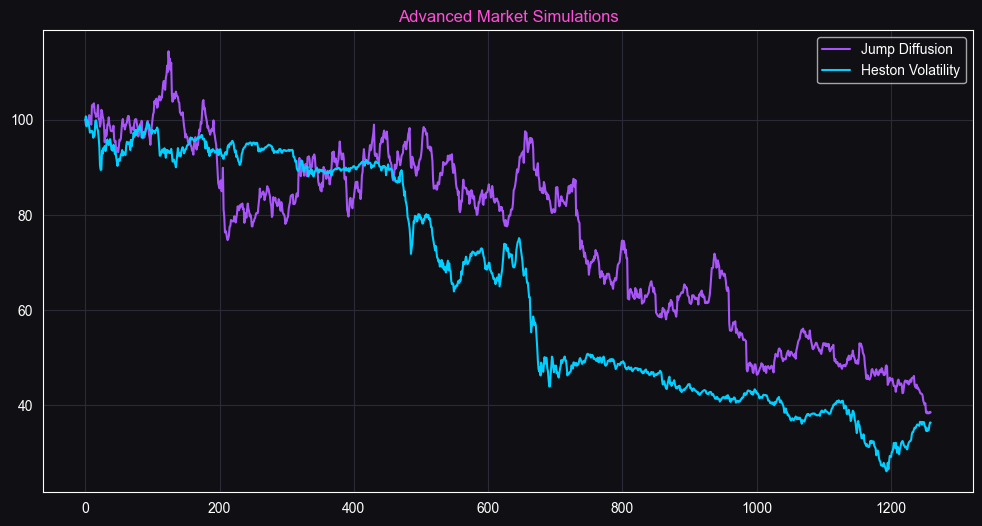

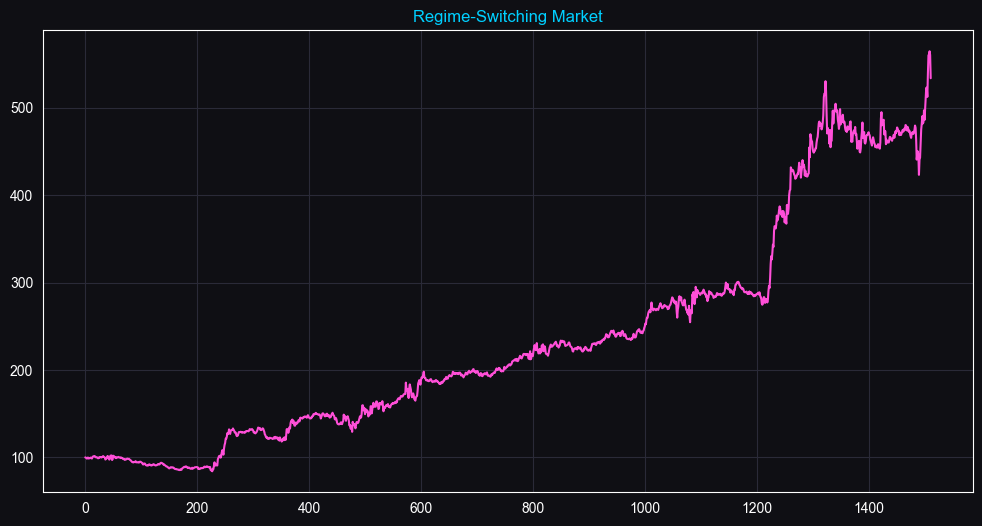

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
Model is not converging.  Current: 4652.803513583343 is not greater than 4652.898000914428. Delta is -0.09448733108456508


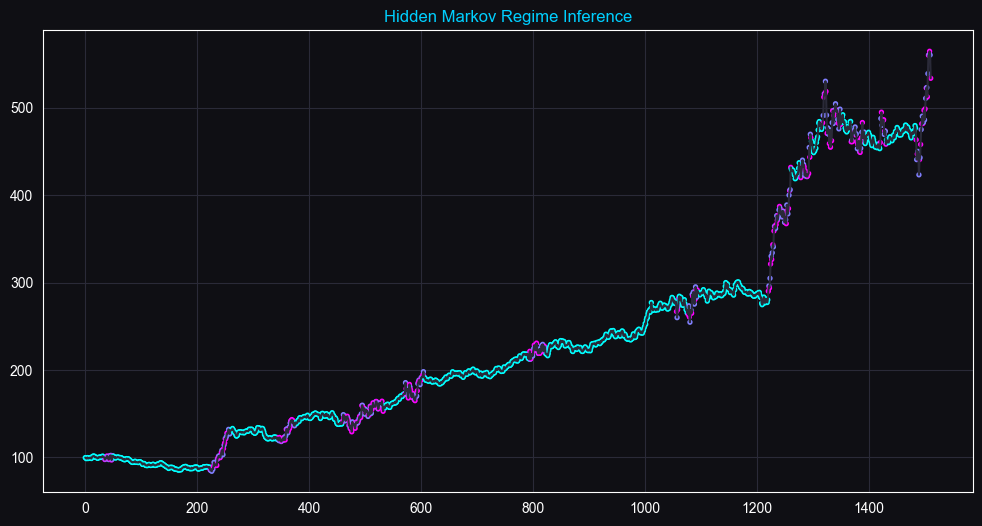

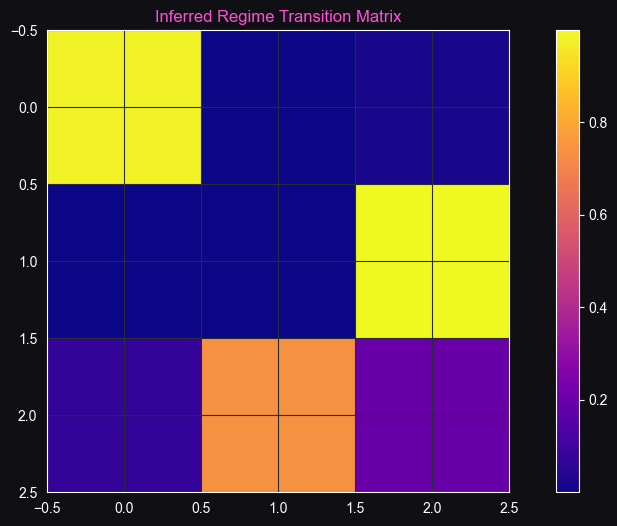

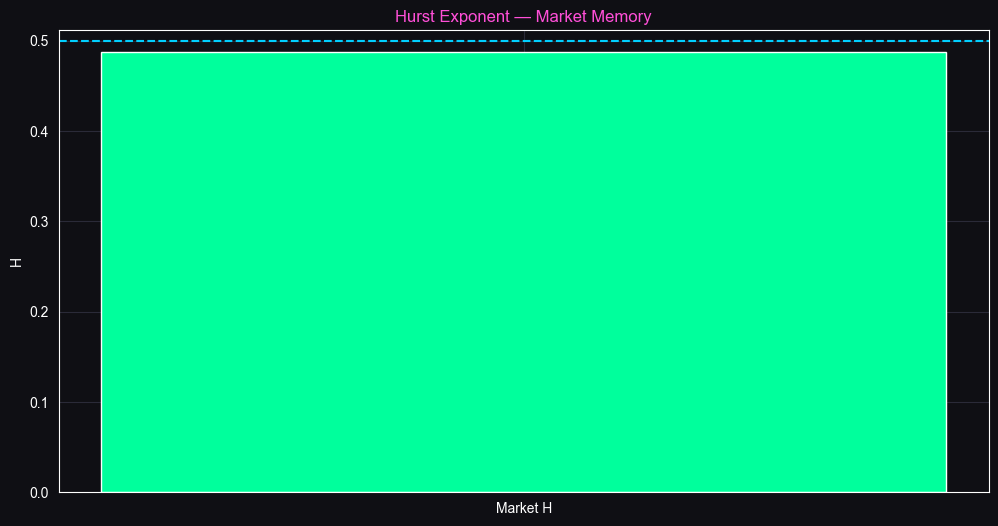

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from hmmlearn.hmm import GaussianHMM

# --- STONKS THEME COLORS ---
STONKS_GREEN = "#00ff9c"
STONKS_PINK  = "#ff4fd8"
STONKS_BLUE  = "#00cfff"
STONKS_PURPLE = "#a855f7"
BG = "#0f0f14"
GRID = "#2a2a38"

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.facecolor'] = BG
plt.rcParams['figure.facecolor'] = BG
plt.rcParams['grid.color'] = GRID

np.random.seed(42)

## Classical Stochastic Processes
#
# We begin by implementing classical models for asset price behavior.

def simulate_gbm(T=252*5, mu=0.08, sigma=0.2, s0=100):
    dt = 1/252
    returns = np.random.normal((mu - 0.5*sigma**2)*dt, sigma*np.sqrt(dt), T)
    return pd.Series(s0 * np.exp(np.cumsum(returns)))


def simulate_ou(T=252*5, theta=0.2, mu=100, sigma=0.3, x0=100):
    dt = 1/252
    x = np.zeros(T)
    x[0] = x0
    for t in range(1, T):
        x[t] = x[t-1] + theta*(mu - x[t-1])*dt + sigma*np.sqrt(dt)*np.random.randn()
    return pd.Series(x)

price_gbm = simulate_gbm()
price_ou = simulate_ou()

plt.plot(price_gbm, color=STONKS_PINK, label="GBM")
plt.plot(price_ou, color=STONKS_GREEN, label="OU")
plt.title("Classical Stochastic Markets", color=STONKS_BLUE)
plt.legend()
plt.grid(True)
plt.show()

## Advanced Market Dynamics
#
# We now implement advanced stochastic models capturing real-world features.

def simulate_jump_diffusion(T=252*5, mu=0.07, sigma=0.2, lam=0.05, jump_mu=-0.02, jump_sigma=0.05, s0=100):
    dt = 1/252
    prices = [s0]
    for _ in range(T-1):
        jump = np.random.normal(jump_mu, jump_sigma) if np.random.rand() < lam else 0
        ret = (mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.randn() + jump
        prices.append(prices[-1] * np.exp(ret))
    return pd.Series(prices)


def simulate_heston(T=252*5, mu=0.06, kappa=3, theta=0.04, sigma_v=0.5, rho=-0.7, s0=100):
    dt = 1/252
    v = theta
    s = s0
    prices = []
    for _ in range(T):
        z1 = np.random.randn()
        z2 = rho*z1 + np.sqrt(1-rho**2)*np.random.randn()
        v = np.abs(v + kappa*(theta - v)*dt + sigma_v*np.sqrt(v*dt)*z2)
        s *= np.exp((mu - 0.5*v)*dt + np.sqrt(v*dt)*z1)
        prices.append(s)
    return pd.Series(prices)

price_jump = simulate_jump_diffusion()
price_heston = simulate_heston()

plt.plot(price_jump, color=STONKS_PURPLE, label="Jump Diffusion")
plt.plot(price_heston, color=STONKS_BLUE, label="Heston Volatility")
plt.title("Advanced Market Simulations", color=STONKS_PINK)
plt.legend()
plt.grid(True)
plt.show()


## Markov Regime-Switching Market
#
# We construct a multi-regime market switching between:
# - Low volatility
# - Medium volatility
# - High volatility

def simulate_regime_switching(T=252*6, s0=100):
    regimes = [0]
    prices = [s0]

    P = np.array([[0.97, 0.02, 0.01],
                  [0.03, 0.94, 0.03],
                  [0.02, 0.06, 0.92]])

    params = {
        0: (0.05, 0.10),
        1: (0.07, 0.20),
        2: (0.02, 0.45)
    }

    for _ in range(T-1):
        curr = regimes[-1]
        next_state = np.random.choice([0,1,2], p=P[curr])
        mu, sigma = params[next_state]
        ret = np.random.normal((mu - 0.5*sigma**2)/252, sigma/np.sqrt(252))
        prices.append(prices[-1] * np.exp(ret))
        regimes.append(next_state)

    return pd.Series(prices), pd.Series(regimes)

price_rs, true_regimes = simulate_regime_switching()

plt.plot(price_rs, color=STONKS_PINK)
plt.title("Regime-Switching Market", color=STONKS_BLUE)
plt.grid(True)
plt.show()

## Hidden Markov Model — Regime Inference

returns = np.diff(np.log(price_rs)).reshape(-1,1)

hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=200)
hmm.fit(returns)

inferred_states = hmm.predict(returns)

# %%
fig, ax = plt.subplots()
ax.plot(price_rs.values[1:], color=GRID)
ax.scatter(range(len(inferred_states)), price_rs.values[1:], c=inferred_states,
           cmap='cool', s=8)
ax.set_title("Hidden Markov Regime Inference", color=STONKS_BLUE)
ax.grid(True)
plt.show()

## Regime Transition Dynamics

plt.imshow(hmm.transmat_, cmap='plasma')
plt.colorbar()
plt.title("Inferred Regime Transition Matrix", color=STONKS_PINK)
plt.show()

## Regime Characterization

regime_stats = {}
for i in range(3):
    idx = inferred_states == i
    regime_stats[f"Regime {i}"] = {
        "Volatility": returns[idx].std() * np.sqrt(252),
        "Drift": returns[idx].mean() * 252
    }

pd.DataFrame(regime_stats).T

## Market Structure Diagnostics

def hurst(ts):
    lags = range(2, 100)
    tau = [np.std(ts[lag:] - ts[:-lag]) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]

h = hurst(price_rs.values)
h

plt.bar(["Market H"], [h], color=STONKS_GREEN)
plt.axhline(0.5, linestyle='--', color=STONKS_BLUE)
plt.title("Hurst Exponent — Market Memory", color=STONKS_PINK)
plt.ylabel("H")
plt.grid(True)
plt.show()

## Nonlinear Market Geometry

def correlation_dimension(x, m=10, r=0.5):
    N = len(x)
    C = 0
    for i in range(N-m):
        for j in range(i+1, N-m):
            dist = np.linalg.norm(x[i:i+m] - x[j:j+m])
            if dist < r:
                C += 1
    return np.log(C+1) / np.log(r)

cd = correlation_dimension(np.diff(np.log(price_rs.values)))
cd

plt.bar(["Market Fractal Dim."], [cd], color=STONKS_PURPLE)
plt.title("Nonlinear Market Geometry — Fractal Dimension", color=STONKS_BLUE)
plt.ylabel("Dimension")
plt.grid(True)
plt.show()